In [9]:
%load_ext autoreload
%autoreload 2

import sys, os
src_path = os.path.join(os.getcwd(), "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:

from src.utils import Utils
from src.fastbdt import train_fastbdt
from src.dts import train_decision_tree, train_random_forest
from src.xgb_model import train_xgboost
from src.nn import train_neural_network

# Decision Trees

In [12]:
dt_results = train_decision_tree(
    data = Utils.data_import('data/data_hep - data_hep.csv')
)


Decision Tree - Total features: 59
Decision Tree - Reduced features (importance >= 0.01): 14
Saved Decision Tree model to models/decision_tree_model.pkl


In [13]:
dt_results['accuracy']

0.7922764611462563

# Random Forest

In [14]:
rf_results = train_random_forest(
    data = Utils.data_import('data/data_hep - data_hep.csv')
)


Random Forest - Total features: 59
Random Forest - Reduced features (importance >= 0.01): 29
Saved Random Forest model to models/random_forest_model.pkl


In [15]:
rf_results['accuracy']

0.8589840430554244

# XGBoost

In [16]:
xgb_results = train_xgboost(
    data = Utils.data_import('data/data_hep - data_hep.csv')
)

/home/ardo/HCP_Belle_Cllassification/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:56:57] WARNING: /workspace/src/context.cc:62: Only 1 GPUs are visible, setting device ordinal to 0
  self.starting_round = model.num_boosted_rounds()


In [17]:
xgb_results['accuracy']

0.8768765933339628

# FastBDT

In [18]:
fbdt_results = train_fastbdt(
    data = Utils.data_import('data/data_hep - data_hep.csv'),
    nTrees = 400,
    depth = 6,
    shrinkage = 0.1,
    subsample = 0.5,
    binning=None
)

In [19]:
fbdt_results['accuracy']

0.8777735813426494

In [20]:
nTrees = [100, 200, 400, 800]
depth = [3, 5, 7]
shrinkage = [0.05, 0.1, 0.2]
subsample = [0.5, 0.7, 1.0]
binning = [6, 8, 10]



In [39]:
features = [dt_results['reduced_features'],
            rf_results['reduced_features'],
            xgb_results['reduced_features'],
            fbdt_results['reduced_features']]

df = Utils.data_import('data/data_hep - data_hep.csv')

reduced_features = features[2] + ['index', 'type']
reduced_df = df[reduced_features]


In [41]:
xgb_results_red = train_xgboost(
    data = reduced_df
)

xgb_results_red['accuracy']

/home/ardo/HCP_Belle_Cllassification/src/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = df['type'].isin([0, 1]).astype(int)
/home/ardo/HCP_Belle_Cllassification/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:18:33] WARNING: /workspace/src/context.cc:62: Only 1 GPUs are visible, setting device ordinal to 0
  self.starting_round = model.num_boosted_rounds()


0.8769710131243509

In [44]:
fastbdt_results_red = train_fastbdt(
    data = reduced_df,
    nTrees = 400,
    depth = 6,
    shrinkage = 0.1,
    subsample = 0.5,
    binning=None
)
fastbdt_results_red['accuracy']

/home/ardo/HCP_Belle_Cllassification/src/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = df['type'].isin([0, 1]).astype(int)


0.8773959021810972

In [42]:
len(xgb_results_red['reduced_features'])

41

In [43]:
len(xgb_results['reduced_features'])

41

### Compare ROC

Model: Decision Tree | Area Under ROC Curve (AUC): 0.7923
Model: Random Forest | Area Under ROC Curve (AUC): 0.9318
Model: XGBoost | Area Under ROC Curve (AUC): 0.9492
Model: FastBDT | Area Under ROC Curve (AUC): 0.9474

Generating ROC curve comparison plot...
Plot saved as 'plots/roc_comparison.png'


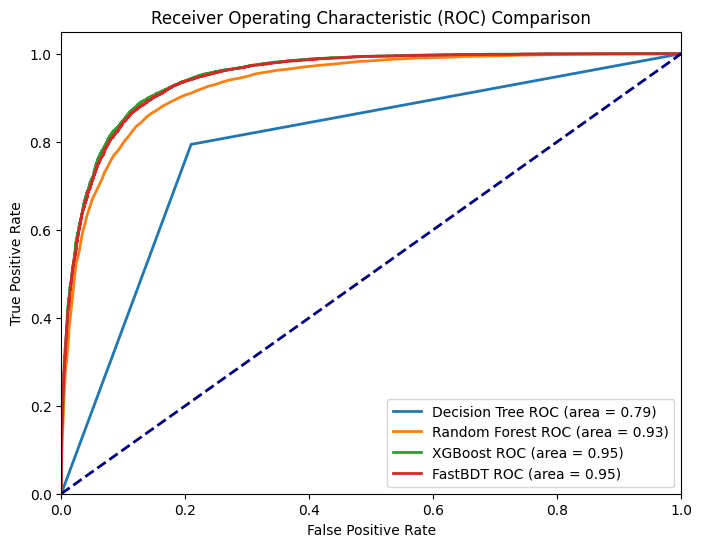

In [35]:
dt_roc = dt_results['roc_curve']
rf_roc = rf_results['roc_curve']
xgb_roc = xgb_results['roc_curve']
fbdt_roc = fbdt_results['roc_curve']


Utils.plot_roc_comparison(
    [('Decision Tree', dt_roc),
     ('Random Forest', rf_roc),
     ('XGBoost', xgb_roc),
     ('FastBDT', fbdt_roc)],
    plotname='roc_comparison.png'
)

## NN


In [36]:
nn_results = train_neural_network(
    Utils.data_import('data/data_hep - data_hep.csv'),
    epochs=50
)

Model saved to 'models/neural_network_model.pt'


In [37]:
nn_results['accuracy']

0.8722500236049476

In [38]:
"""
Model Comparison Script
Compares TabNet and FastBDT models side-by-side
Plots ROC curves together for direct comparison
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, classification_report
import os

from src.utils import Utils
from src.tabnet_wrapper import TabNetClassifier
from PyFastBDT import FastBDT


def compare_tabnet_and_fastbdt(data_path='data/data_hep - data_hep.csv', 
                               plot_dir='plots',
                               load_tabnet_model=None):
    """
    Train and compare TabNet and FastBDT models
    
    Args:
        data_path: Path to the data file
        plot_dir: Directory to save comparison plots
        load_tabnet_model: Path to pre-trained TabNet model (optional)
    """
    print("="*80)
    print("MODEL COMPARISON: TabNet vs FastBDT")
    print("="*80)
    
    os.makedirs(plot_dir, exist_ok=True)
    
    # Load data
    print("\n[1/5] Loading and preparing data...")
    df = Utils.data_import(data_path)
    X, y = Utils.bin_classification(df)
    
    print(f"Dataset shape: {X.shape}")
    print(f"Signal distribution: {y.value_counts().to_dict()}")
    
    # Split data - CONVERT TO NUMPY ARRAYS
    X_train, X_test, y_train, y_test = Utils.data_split(X, y, ratio=0.3)
    
    # Convert to numpy arrays to avoid pandas Series issues
    X_train = X_train.values if hasattr(X_train, 'values') else X_train
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    y_train = y_train.values if hasattr(y_train, 'values') else y_train
    y_test = y_test.values if hasattr(y_test, 'values') else y_test
    
    # Create validation split from training data
    from sklearn.model_selection import train_test_split
    X_train_tabnet, X_val_tabnet, y_train_tabnet, y_val_tabnet = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"  - TabNet Training: {len(X_train_tabnet)} samples")
    print(f"  - TabNet Validation: {len(X_val_tabnet)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # ========================
    # Train TabNet
    # ========================
    print("\n[2/5] Training TabNet...")
    print("-" * 80)
    
    tabnet_clf = TabNetClassifier(
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.5,
        learning_rate=2e-2,
        batch_size=256,
        virtual_batch_size=128,
        max_epochs=50,
        patience=10
    )
    
    tabnet_clf.fit(X_train_tabnet, y_train_tabnet, X_val_tabnet, y_val_tabnet, verbose=True)
    
    # TabNet Predictions
    y_pred_tabnet_proba = tabnet_clf.predict_proba(X_test)
    y_pred_tabnet = (y_pred_tabnet_proba > 0.5).astype(int)
    
    # TabNet Metrics
    tabnet_accuracy = accuracy_score(y_test, y_pred_tabnet)
    tabnet_auc = roc_auc_score(y_test, y_pred_tabnet_proba)
    fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, y_pred_tabnet_proba)
    
    print(f"\n✓ TabNet Results:")
    print(f"  Accuracy: {tabnet_accuracy:.4f}")
    print(f"  ROC AUC:  {tabnet_auc:.4f}")
    
    # ========================
    # Train FastBDT
    # ========================
    print("\n[3/5] Training FastBDT...")
    print("-" * 80)
    
    bdt = FastBDT.Classifier()
    bdt.fit(X_train, y_train)
    
    # FastBDT Predictions
    y_pred_bdt_scores = bdt.predict(X_test)
    y_pred_bdt = (y_pred_bdt_scores > 0.5).astype(int)
    
    # FastBDT Metrics
    bdt_accuracy = accuracy_score(y_test, y_pred_bdt)
    bdt_auc = roc_auc_score(y_test, y_pred_bdt_scores)
    fpr_bdt, tpr_bdt, _ = roc_curve(y_test, y_pred_bdt_scores)
    
    print(f"\n✓ FastBDT Results:")
    print(f"  Accuracy: {bdt_accuracy:.4f}")
    print(f"  ROC AUC:  {bdt_auc:.4f}")
    
    # ========================
    # Comparison Summary
    # ========================
    print("\n[4/5] Model Comparison Summary")
    print("="*80)
    
    comparison_df = pd.DataFrame({
        'Model': ['TabNet', 'FastBDT', 'Difference (TabNet - BDT)'],
        'Accuracy': [tabnet_accuracy, bdt_accuracy, tabnet_accuracy - bdt_accuracy],
        'ROC AUC': [tabnet_auc, bdt_auc, tabnet_auc - bdt_auc]
    })
    
    print("\n" + comparison_df.to_string(index=False))
    
    # Determine winner
    print("\n" + "-"*80)
    if tabnet_auc > bdt_auc:
        print(f"🏆 TabNet performs better by {(tabnet_auc - bdt_auc):.4f} AUC points")
    elif bdt_auc > tabnet_auc:
        print(f"🏆 FastBDT performs better by {(bdt_auc - tabnet_auc):.4f} AUC points")
    else:
        print("🤝 Both models perform equally well")
    
    # Statistical significance (rough check)
    diff = abs(tabnet_auc - bdt_auc)
    if diff < 0.01:
        print("   (Difference is negligible - models perform similarly)")
    elif diff < 0.03:
        print("   (Difference is small but noticeable)")
    elif diff < 0.05:
        print("   (Difference is moderate)")
    else:
        print("   (Difference is substantial)")
    
    # ========================
    # Plot Combined ROC Curve
    # ========================
    print("\n[5/5] Generating comparison plots...")
    print("-" * 80)
    
    # Plot 1: Combined ROC Curve
    plt.figure(figsize=(10, 8))
    
    # TabNet ROC
    plt.plot(fpr_tabnet, tpr_tabnet, color='purple', lw=2.5, 
             label=f'TabNet (AUC = {tabnet_auc:.4f})')
    
    # FastBDT ROC
    plt.plot(fpr_bdt, tpr_bdt, color='green', lw=2.5, 
             label=f'FastBDT (AUC = {bdt_auc:.4f})')
    
    # Random classifier baseline
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5000)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Background Efficiency)', fontsize=12)
    plt.ylabel('True Positive Rate (Signal Efficiency)', fontsize=12)
    plt.title('ROC Curve Comparison: TabNet vs FastBDT', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    
    roc_comparison_path = os.path.join(plot_dir, 'roc_comparison_tabnet_vs_fastbdt.png')
    plt.savefig(roc_comparison_path, dpi=150, bbox_inches='tight')
    print(f"✓ Combined ROC curve saved to '{roc_comparison_path}'")
    plt.close()
    
    # Plot 2: Side-by-side Metric Comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Accuracy comparison
    models = ['TabNet', 'FastBDT']
    accuracies = [tabnet_accuracy, bdt_accuracy]
    colors = ['purple', 'green']
    
    bars1 = axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # ROC AUC comparison
    aucs = [tabnet_auc, bdt_auc]
    bars2 = axes[1].bar(models, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('ROC AUC Score', fontsize=12)
    axes[1].set_title('ROC AUC Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, auc_val in zip(bars2, aucs):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{auc_val:.4f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    metrics_comparison_path = os.path.join(plot_dir, 'metrics_comparison_tabnet_vs_fastbdt.png')
    plt.savefig(metrics_comparison_path, dpi=150, bbox_inches='tight')
    print(f"✓ Metrics comparison saved to '{metrics_comparison_path}'")
    plt.close()
    
    # Plot 3: Classification Reports Comparison
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORTS")
    print("="*80)
    
    print("\nTabNet Classification Report:")
    print("-" * 80)
    print(classification_report(y_test, y_pred_tabnet, 
                               target_names=['Signal', 'Background'],
                               digits=4))
    
    print("\nFastBDT Classification Report:")
    print("-" * 80)
    print(classification_report(y_test, y_pred_bdt,
                               target_names=['Signal', 'Background'],
                               digits=4))
    
    # Plot 4: Signal Efficiency at Different Working Points
    plt.figure(figsize=(10, 6))
    
    # Find signal efficiencies at specific background rejection rates
    working_points = [0.5, 0.7, 0.8, 0.9, 0.95]
    
    for fpr_arr, tpr_arr, label, color in [(fpr_tabnet, tpr_tabnet, 'TabNet', 'purple'),
                                             (fpr_bdt, tpr_bdt, 'FastBDT', 'green')]:
        signal_effs = []
        for bg_rej in working_points:
            target_fpr = 1 - bg_rej
            idx = np.argmin(np.abs(fpr_arr - target_fpr))
            signal_effs.append(tpr_arr[idx])
        
        plt.plot([f'{int(wp*100)}%' for wp in working_points], signal_effs, 
                marker='o', markersize=8, linewidth=2, label=label, color=color)
    
    plt.xlabel('Background Rejection Rate', fontsize=12)
    plt.ylabel('Signal Efficiency', fontsize=12)
    plt.title('Signal Efficiency at Different Background Rejection Rates', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.ylim([0, 1])
    
    working_points_path = os.path.join(plot_dir, 'working_points_comparison.png')
    plt.savefig(working_points_path, dpi=150, bbox_inches='tight')
    print(f"✓ Working points comparison saved to '{working_points_path}'")
    plt.close()
    
    print("\n" + "="*80)
    print("COMPARISON COMPLETE!")
    print("="*80)
    print(f"\nAll plots saved to '{plot_dir}/' directory:")
    print(f"  1. {roc_comparison_path}")
    print(f"  2. {metrics_comparison_path}")
    print(f"  3. {working_points_path}")
    
    return {
        'tabnet': {
            'accuracy': tabnet_accuracy,
            'roc_auc': tabnet_auc,
            'fpr': fpr_tabnet,
            'tpr': tpr_tabnet,
            'predictions': y_pred_tabnet,
            'probabilities': y_pred_tabnet_proba,
            'model': tabnet_clf
        },
        'fastbdt': {
            'accuracy': bdt_accuracy,
            'roc_auc': bdt_auc,
            'fpr': fpr_bdt,
            'tpr': tpr_bdt,
            'predictions': y_pred_bdt,
            'probabilities': y_pred_bdt_scores,
            'model': bdt
        },
        'comparison': comparison_df
    }

ModuleNotFoundError: No module named 'src.tabnet_wrapper'

In [ ]:
# Run the comparison
# Option 1: Load pre-trained NN model if available
# results = compare_nn_and_fastbdt(load_nn_model='models/baseline_nn.pt')

# Option 2: Train from scratch (will take a few minutes)
results = compare_tabnet_and_fastbdt()

print("\n✅ Comparison completed successfully!")

MODEL COMPARISON: TabNet vs FastBDT

[1/5] Loading and preparing data...
Dataset shape: (70606, 59)
Signal distribution: {1: 35765, 0: 34841}
Training set: 49424 samples
  - TabNet Training: 39539 samples
  - TabNet Validation: 9885 samples
Test set: 21182 samples

[2/5] Training TabNet...
--------------------------------------------------------------------------------
Dataset shape: (70606, 59)
Signal distribution: {1: 35765, 0: 34841}
Training set: 49424 samples
  - TabNet Training: 39539 samples
  - TabNet Validation: 9885 samples
Test set: 21182 samples

[2/5] Training TabNet...
--------------------------------------------------------------------------------


/home/ardo/HCP_Belle_Cllassification/venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")



🖥️  TABNET DEVICE CONFIGURATION
✅ GPU Available: NVIDIA GeForce GTX 1650
   Memory: 4.29 GB
   CUDA Version: 12.8
   Device: CUDA

epoch 0  | loss: 0.55739 | val_0_auc: 0.89061 | val_0_accuracy: 0.8083  |  0:00:11s
epoch 0  | loss: 0.55739 | val_0_auc: 0.89061 | val_0_accuracy: 0.8083  |  0:00:11s
epoch 1  | loss: 0.40853 | val_0_auc: 0.9006  | val_0_accuracy: 0.81659 |  0:00:21s
epoch 1  | loss: 0.40853 | val_0_auc: 0.9006  | val_0_accuracy: 0.81659 |  0:00:21s
epoch 2  | loss: 0.39821 | val_0_auc: 0.89961 | val_0_accuracy: 0.82236 |  0:00:31s
epoch 2  | loss: 0.39821 | val_0_auc: 0.89961 | val_0_accuracy: 0.82236 |  0:00:31s
epoch 3  | loss: 0.39223 | val_0_auc: 0.90149 | val_0_accuracy: 0.82539 |  0:00:41s
epoch 3  | loss: 0.39223 | val_0_auc: 0.90149 | val_0_accuracy: 0.82539 |  0:00:41s
epoch 4  | loss: 0.38652 | val_0_auc: 0.90265 | val_0_accuracy: 0.82772 |  0:00:51s
epoch 4  | loss: 0.38652 | val_0_auc: 0.90265 | val_0_accuracy: 0.82772 |  0:00:51s
epoch 5  | loss: 0.38325 | v

/home/ardo/HCP_Belle_Cllassification/venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✓ TabNet training completed!
  Best epoch: 43


KeyError: 'val_auc'

In [ ]:
# Check GPU availability before running comparison
import torch

print("="*80)
print("🖥️  HARDWARE CHECK")
print("="*80)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA version: {torch.version.cuda}")
    print("\n   TabNet will use GPU for training (much faster!)")
else:
    print("⚠️  No GPU detected - TabNet will use CPU")
    print("   Expected training time: 5-15 minutes")
    print("\n   To use GPU, ensure:")
    print("   1. CUDA-capable GPU is installed")
    print("   2. NVIDIA drivers are installed")
    print("   3. PyTorch with CUDA support is installed")
print("="*80)

🖥️  HARDWARE CHECK
PyTorch version: 2.9.0+cu128
CUDA available: True
✅ GPU detected: NVIDIA GeForce GTX 1650
   GPU Memory: 4.29 GB
   CUDA version: 12.8

   TabNet will use GPU for training (much faster!)
✅ GPU detected: NVIDIA GeForce GTX 1650
   GPU Memory: 4.29 GB
   CUDA version: 12.8

   TabNet will use GPU for training (much faster!)
